In [1]:
import cv2
import scipy.signal as signal
import scipy.fft as fft

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import skimage.io as skio

from skimage.color import rgb2gray
import skimage as sk
from align_image_code import align_images

In [2]:
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

<h2>Part 1</h2>

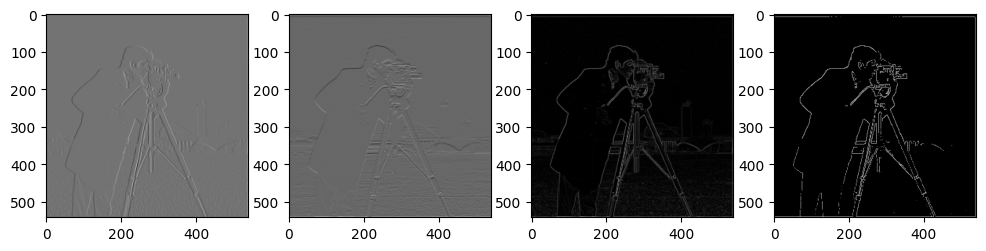

In [3]:
# Q1.1 - Partial Derivatives
%matplotlib inline

# Partial x and y derivatives

img = skio.imread("../images/cameraman.png")
img = rgb2gray(img[:,:,:3])
# plt.imshow(img)

D_x = np.tile(np.array([1,-1])[None,:], [2, 1])
D_y = np.tile(np.array([1,-1]).T[:,None], [1, 2])

# Dx
img_D_x = signal.convolve2d(img, D_x, mode="same")
# Dy
img_D_y = signal.convolve2d(img, D_y, mode="same")

gradient_mag = normalize(np.sqrt(((img_D_x**2) + (img_D_y**2))))
# print(gradient_mag)
img_binarize = np.where(gradient_mag >= 0.3, 1, 0)

plt.figure(figsize=(12, 4))
plt.subplot(141); plt.imshow(img_D_x, cmap="gray")
plt.subplot(142); plt.imshow(img_D_y, cmap="gray")
plt.subplot(143); plt.imshow(gradient_mag, cmap="gray")
plt.subplot(144); plt.imshow(img_binarize, cmap="gray")

# print(img_binarize)

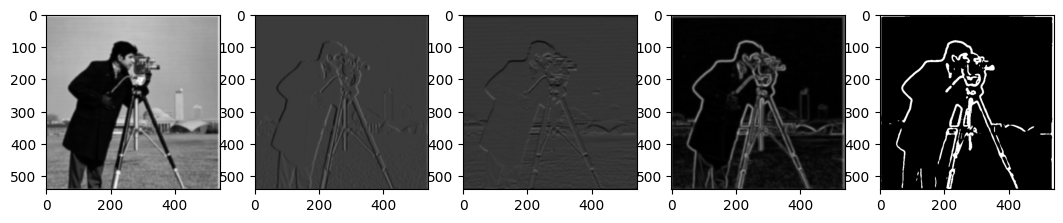

In [4]:
# Q1.2 - Gaussian Blurring
# Gaussian Kernel
gauss_2d_kernel = cv2.getGaussianKernel(15, 2) * cv2.getGaussianKernel(15, 2).T

# Convolution
img_gauss = signal.convolve2d(img, gauss_2d_kernel, mode="same")

# Gauss D_x
gauss_D_x = signal.convolve2d(img_gauss, D_x, mode="same")

# Gauss D_y
gauss_D_y = signal.convolve2d(img_gauss, D_y, mode="same")

gauss_gm = np.sqrt((gauss_D_x**2)+(gauss_D_y**2))
img_gauss_gm = signal.convolve2d(gauss_gm, gauss_2d_kernel, mode="same")
img_gauss_binarize = np.where(img_gauss_gm >= 0.1, 1, 0)

plt.figure(figsize=(13, 6))
plt.subplot(151); plt.imshow(img_gauss, cmap="gray")
plt.subplot(152); plt.imshow(gauss_D_x, cmap="gray")
plt.subplot(153); plt.imshow(gauss_D_y, cmap="gray")
plt.subplot(154); plt.imshow(img_gauss_gm, cmap="gray")
plt.subplot(155); plt.imshow(img_gauss_binarize, cmap="gray")

Differences: The regularly convuluted images are brighter and sharper, compared to the gaussian convoluted images which are dark and smooth. Also, the lines of the regular edge filter is much thinner than the gaussian edge filter.

<h2>Part 2</h2>

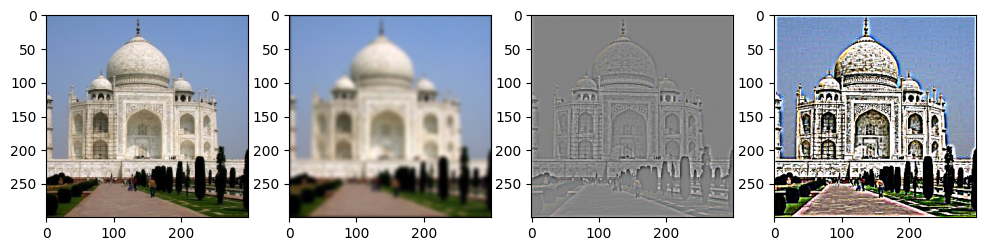

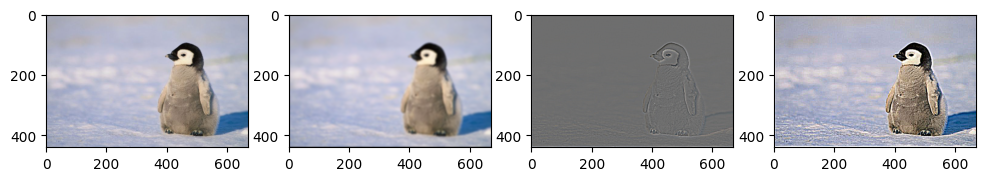

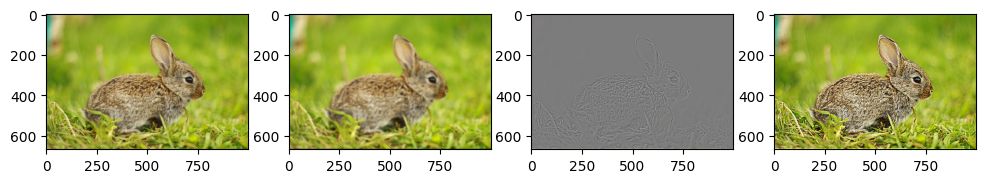

In [5]:
# Q 2.1 - "Sharpening"
taj = skio.imread("../images/taj.jpg")/255
tb, tg, tr = cv2.split(taj)

chick = skio.imread("../images/chick.jpeg")/255
cb, cg, cr = cv2.split(chick)

bunny = skio.imread("../images/bunny.jpg")/255
bb, bg, br = cv2.split(bunny)

gauss_2d_kernel = cv2.getGaussianKernel(10, 3) * cv2.getGaussianKernel(10, 3).T

def sharpen(img, b, g, r, alpha):
    b_lp = signal.convolve2d(b, gauss_2d_kernel, mode="same")
    g_lp = signal.convolve2d(g, gauss_2d_kernel, mode="same")
    r_lp = signal.convolve2d(r, gauss_2d_kernel, mode="same")

    lp = np.dstack([b_lp, g_lp, r_lp])
    hp = img - lp

    img_sharpened = img + (alpha * hp)
    return [normalize(img), normalize(lp), normalize(hp), np.clip(img_sharpened, 0, 1)]

st = sharpen(taj, tb, tg, tr, 8)
sp = sharpen(chick, cb, cg, cr, 4)
sb = sharpen(bunny, bb, bg, br, 2)

plt.figure(figsize=(12, 4))
plt.subplot(141); plt.imshow(st[0], cmap="gray")
plt.subplot(142); plt.imshow(st[1], cmap="gray")
plt.subplot(143); plt.imshow(st[2], cmap="gray")
plt.subplot(144); plt.imshow(st[3], cmap="gray")

plt.figure(figsize=(12, 4))
plt.subplot(141); plt.imshow(sp[0], cmap="gray")
plt.subplot(142); plt.imshow(sp[1], cmap="gray")
plt.subplot(143); plt.imshow(sp[2], cmap="gray")
plt.subplot(144); plt.imshow(sp[3], cmap="gray")

plt.figure(figsize=(12, 4))
plt.subplot(141); plt.imshow(sb[0], cmap="gray")
plt.subplot(142); plt.imshow(sb[1], cmap="gray")
plt.subplot(143); plt.imshow(sb[2], cmap="gray")
plt.subplot(144); plt.imshow(sb[3], cmap="gray")

In [6]:
# Q2.2 - Hybrid Image

# First load images

# high sf
im1 = plt.imread('../images/DerekPicture.jpg')/255

# low sf
im2 = plt.imread('../images/nutmeg.jpg')/255

%matplotlib qt5

# Next align images (this code is provided, but may be improved)
im2_aligned, im1_aligned = align_images(im2, im1)
im1_aligned, im2_aligned = rgb2gray(im1_aligned), rgb2gray(im2_aligned)

## You will provide the code below. Sigma1 and sigma2 are arbitrary 
## cutoff values for the high and low frequencies

def create_gaussian_kernel(ksize, sigma):
    return cv2.getGaussianKernel(ksize, sigma) * cv2.getGaussianKernel(ksize, sigma).T

def hybrid_image(image1, image2, kernel1, kernel2, sigma1, sigma2):
    # print(im1.shape)
    # print(im2.shape)
    lp_filter = signal.convolve2d(image1, create_gaussian_kernel(kernel1, sigma1), mode="same")
    lp = lp_filter
    hp_filter = image2 - signal.convolve2d(image2, create_gaussian_kernel(kernel2, sigma2), mode="same")
    hp = hp_filter
    return [lp, hp, (hp_filter + lp_filter) / 2]

k1 = 10
k2 = 50
s1 = 3
s2 = 30
lp, hp, hybrid = hybrid_image(im1_aligned, im2_aligned, k1, k2, s1, s2)
# print(hybrid.shape)

plt.imshow(hybrid)
plt.show

# ## Compute and display Gaussian and Laplacian Pyramids
# ## You also need to supply this function
# N = 5 # suggested number of pyramid levels (your choice)
# pyramids(hybrid, N)

plt.imshow(hybrid, cmap="gray")

Please select 2 points in each image for alignment.


In [7]:
# Quail/Seal = Squail
im1 = normalize(plt.imread('../images/quail.jpg')/255)
im2 = normalize(plt.imread('../images/seal.png')/255)

im2_aligned, im1_aligned = align_images(im2, im1)
im1_aligned, im2_aligned = rgb2gray(im1_aligned), rgb2gray(im2_aligned)

k1 = 10
k2 = 20
s1 = 3
s2 = 10
se_lp, se_hp, se_hybrid = hybrid_image(im1_aligned, im2_aligned, k1, k2, s1, s2)

plt.imshow(se_hybrid)
plt.show

plt.imshow(se_hybrid, cmap="gray")

Please select 2 points in each image for alignment.


In [27]:
%matplotlib qt5

# Lion/Tiger = Liger
im1 = normalize(plt.imread('../images/lion.jpg')/255)
im1 = cv2.resize(im1, (640, 480))
im2 = normalize(plt.imread('../images/tiger.jpg')/255)

# print(im1.shape, im2.shape)

im2_aligned, im1_aligned = align_images(im2, im1)
im1_aligned, im2_aligned = rgb2gray(im1_aligned), rgb2gray(im2_aligned)

k1 = 10
k2 = 10
s1 = 3
s2 = 2
li_lp, li_hp, li_hybrid = hybrid_image(im1_aligned, im2_aligned, k1, k2, s1, s2)

plt.imshow(li_hybrid)
plt.show

plt.imshow(li_hybrid, cmap="gray")

Please select 2 points in each image for alignment.


In [41]:
%matplotlib qt5

# Batman/Joker
im1 = normalize(plt.imread('../images/batman.png')/255)
im2 = normalize(plt.imread('../images/joker.png')/255)

# print(im1.shape, im2.shape)

im2_aligned, im1_aligned = align_images(im2, im1)
im1_aligned, im2_aligned = rgb2gray(im1_aligned), rgb2gray(im2_aligned)

k1 = 10
k2 = 20
s1 = 3
s2 = 10
bj_lp, bj_hp, bj_hybrid = hybrid_image(im1_aligned, im2_aligned, k1, k2, s1, s2)

plt.imshow(bj_hybrid)
plt.show

plt.imshow(bj_hybrid, cmap="gray")

Please select 2 points in each image for alignment.


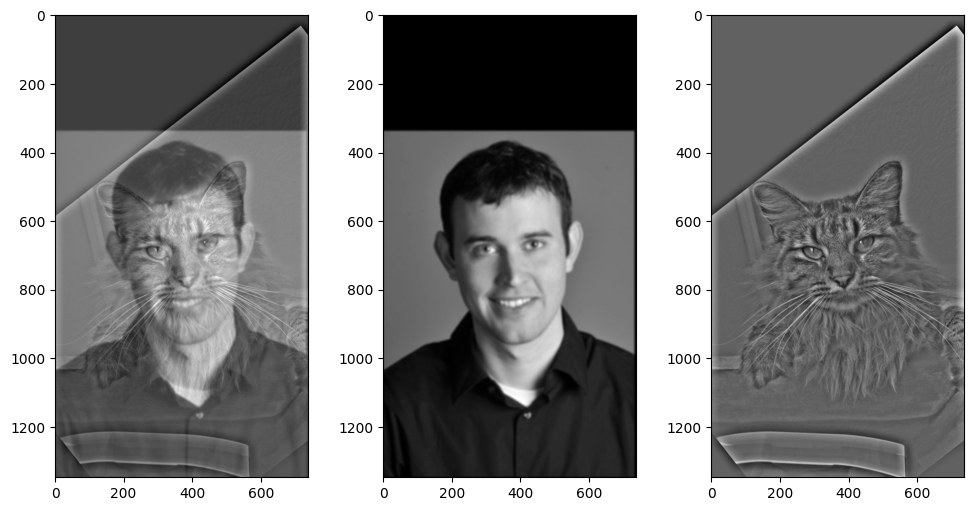

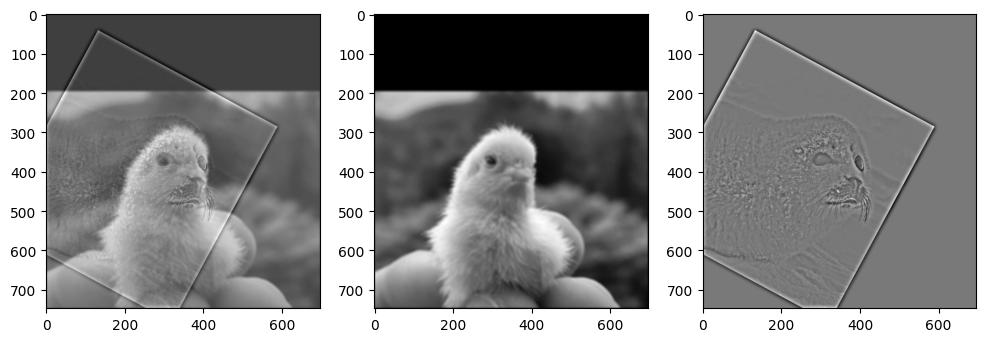

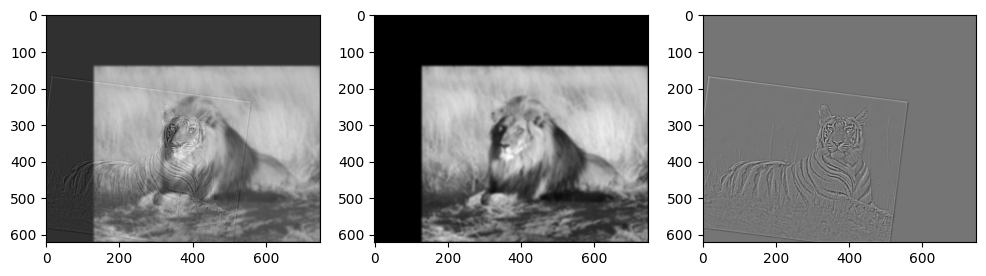

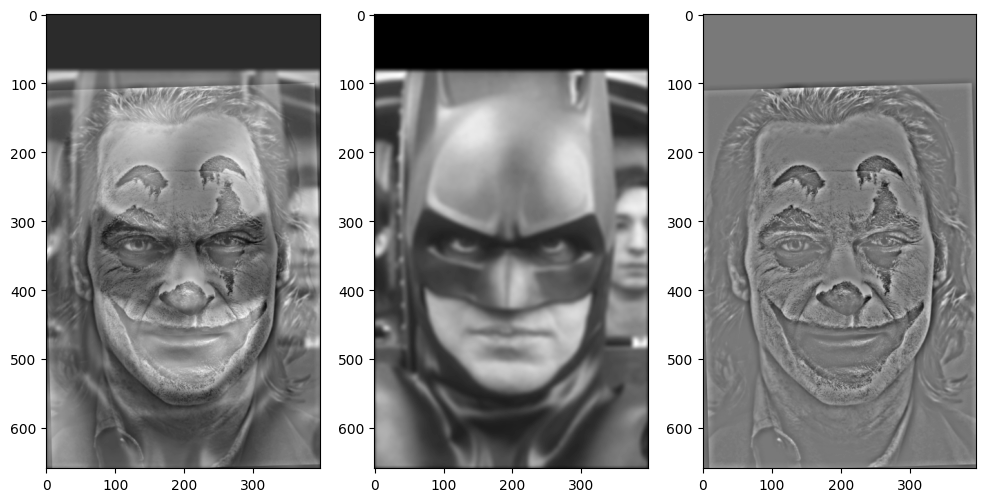

In [42]:
def display_hybrid(h, lp, hp):
    plt.figure(figsize=(12, 6))
    plt.subplot(131); plt.imshow(h, cmap="gray")
    plt.subplot(132); plt.imshow(lp, cmap="gray")
    plt.subplot(133); plt.imshow(hp, cmap="gray")

%matplotlib inline
display_hybrid(hybrid, lp, hp)
display_hybrid(se_hybrid, se_lp, se_hp)
display_hybrid(li_hybrid, li_lp, li_hp)
display_hybrid(bj_hybrid, bj_lp, bj_hp)

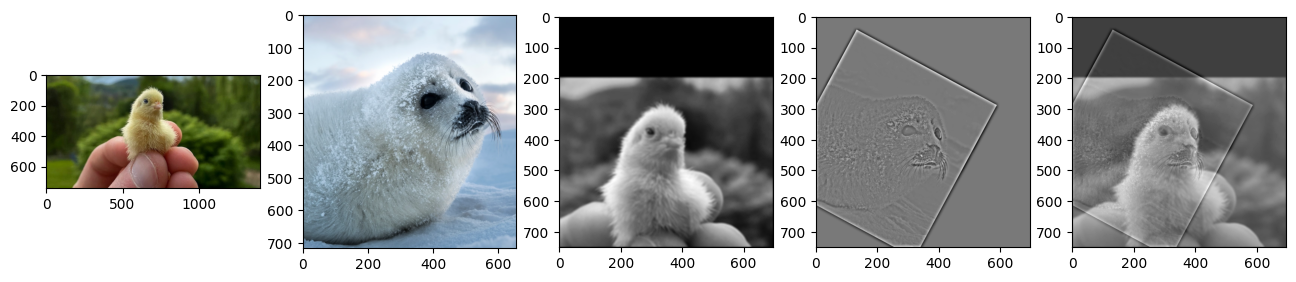

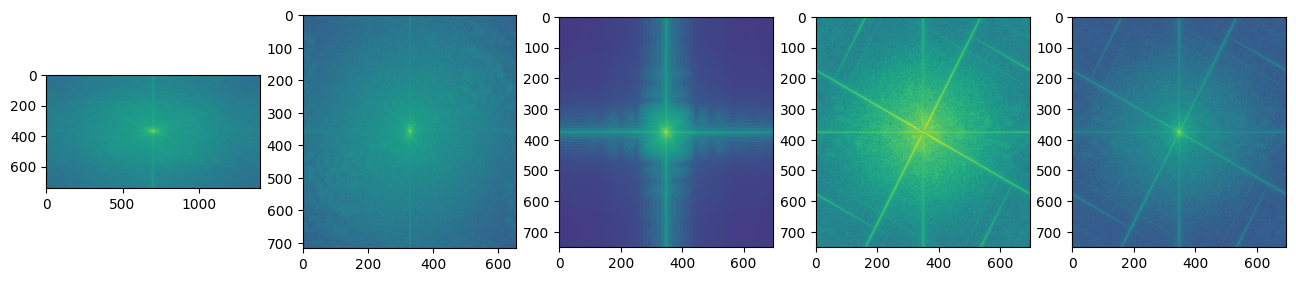

In [10]:
quail = normalize(plt.imread('../images/quail.jpg')/255)
seal = normalize(plt.imread('../images/seal.png')/255)

fft_quail = np.log(np.abs(np.fft.fftshift(np.fft.fft2(rgb2gray(quail)))))
fft_seal = np.log(np.abs(np.fft.fftshift(np.fft.fft2(rgb2gray(seal[:,:,:3])))))
fft_se_lp = np.log(np.abs(np.fft.fftshift(np.fft.fft2(se_lp))))
fft_se_hp = np.log(np.abs(np.fft.fftshift(np.fft.fft2(se_hp))))
fft_se_hybrid = np.log(np.abs(np.fft.fftshift(np.fft.fft2(se_hybrid))))

plt.figure(figsize=(16, 4))
plt.subplot(151); plt.imshow(quail, cmap="gray")
plt.subplot(152); plt.imshow(seal, cmap="gray")
plt.subplot(153); plt.imshow(se_lp, cmap="gray")
plt.subplot(154); plt.imshow(se_hp, cmap="gray")
plt.subplot(155); plt.imshow(se_hybrid, cmap="gray")

plt.figure(figsize=(16, 4))
plt.subplot(151); plt.imshow(fft_quail)
plt.subplot(152); plt.imshow(fft_seal)
plt.subplot(153); plt.imshow(fft_se_lp)
plt.subplot(154); plt.imshow(fft_se_hp)
plt.subplot(155); plt.imshow(fft_se_hybrid)

In [11]:
# Q2.3 - Gaussian and Laplacian Stacks
%matplotlib inline

apple = plt.imread('../images/apple.jpeg')/255
orange = plt.imread('../images/orange.jpeg')/255
# print(apple.shape, orange.shape)

def gaussian_stack(image, ksize, sigma):
    res = [normalize(image)]

    b, g, r = cv2.split(image)

    # ksize = 2
    # sigma = 32
    while sigma > 2:
        # print(int(ksize), sigma)
        gk = create_gaussian_kernel(int(ksize), sigma)

        b_lp = signal.convolve2d(b, gk, mode="same")
        g_lp = signal.convolve2d(g, gk, mode="same")
        r_lp = signal.convolve2d(r, gk, mode="same")
        lp = np.dstack([b_lp, g_lp, r_lp])

        res.append(normalize(lp))
        ksize *= 2
        sigma /= 2

    return res

def laplacian_stack(gauss_stack):
    res = []
    for i in range(1, len(gauss_stack)):
        res.append(normalize(gauss_stack[i-1] - gauss_stack[i]))
    res.append(gauss_stack[-1])
    return res

def display_stack(stack):
    plt.figure(figsize=(16, 4))
    plt.subplot(151); plt.imshow(stack[0], cmap="gray")
    plt.subplot(152); plt.imshow(stack[1], cmap="gray")
    plt.subplot(153); plt.imshow(stack[2], cmap="gray")
    plt.subplot(154); plt.imshow(stack[3], cmap="gray")
    plt.subplot(155); plt.imshow(stack[4], cmap="gray")

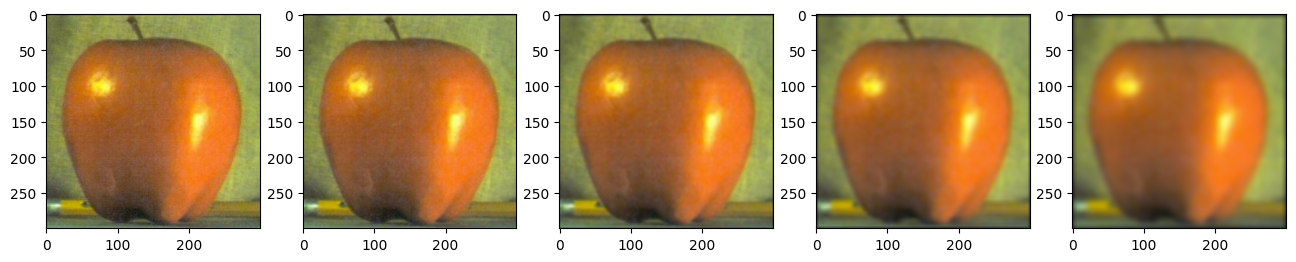

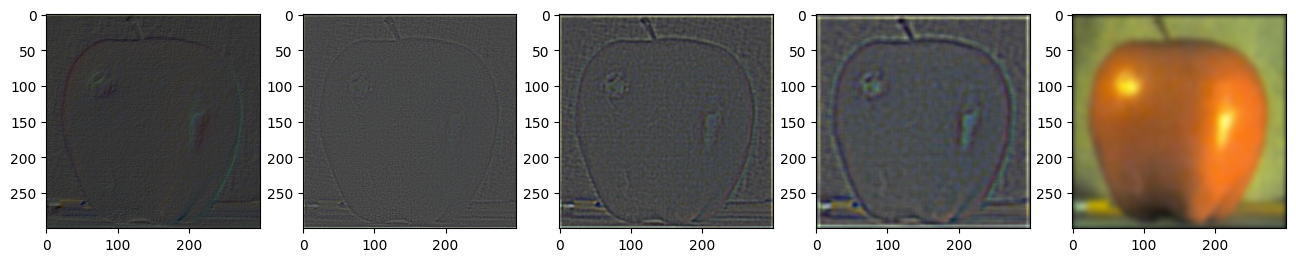

In [12]:
# Apple stacks
apple_gauss_stack = gaussian_stack(apple, 2, 32)
apple_laplacian_stack = laplacian_stack(apple_gauss_stack)

display_stack(apple_gauss_stack)
display_stack(apple_laplacian_stack)

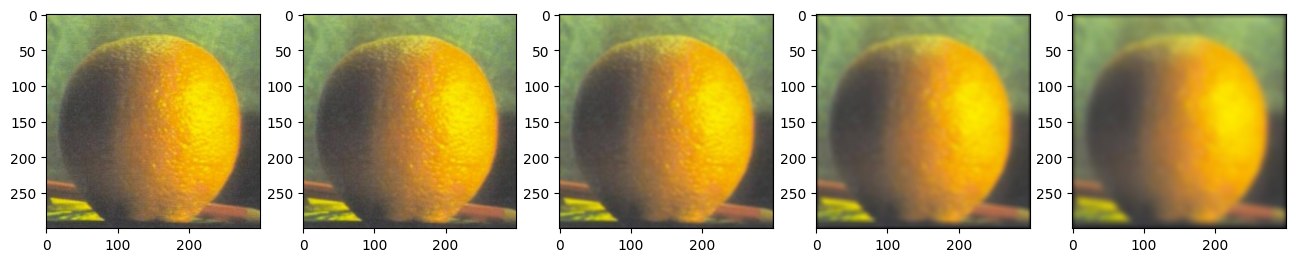

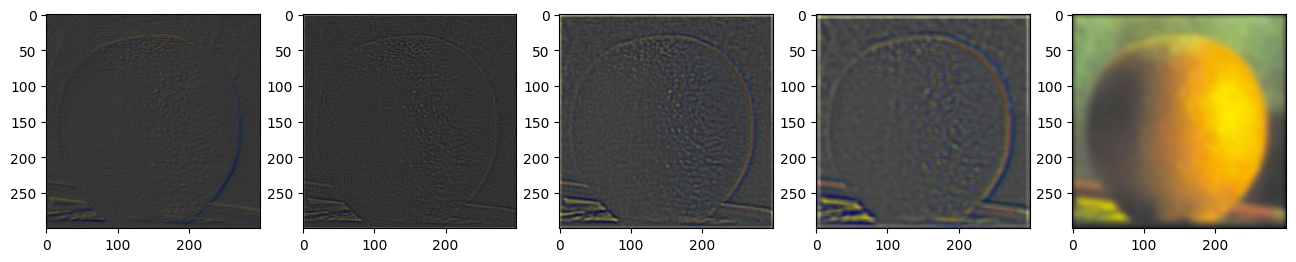

In [13]:
# Orange stack
orange_gauss_stack = gaussian_stack(orange, 2, 32)
orange_laplacian_stack = laplacian_stack(orange_gauss_stack)

display_stack(orange_gauss_stack)
display_stack(orange_laplacian_stack)

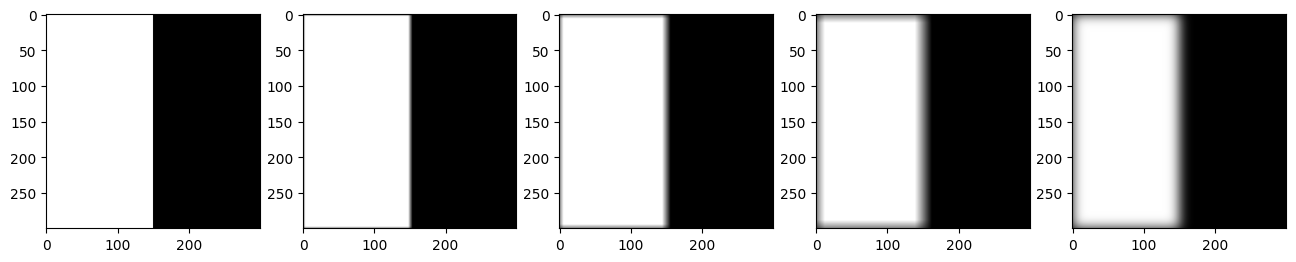

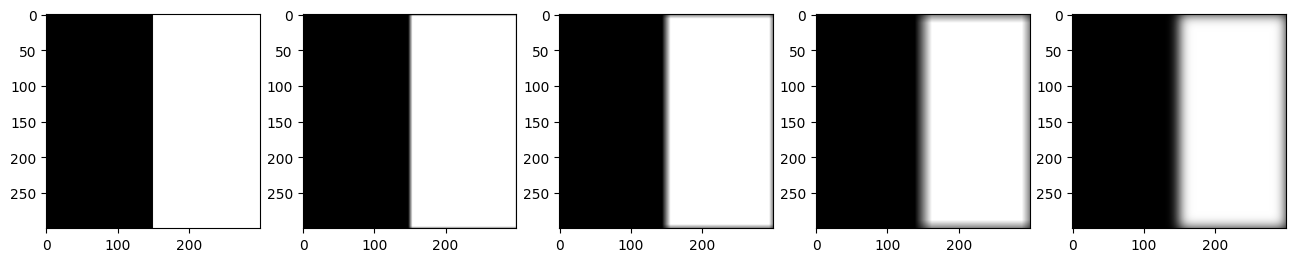

In [14]:
# Gaussian mask
mask_left = plt.imread('../images/mask.jpg')/255
mask_right = 1 - mask_left
mask_left_gs = gaussian_stack(mask_left, 6, 64)
mask_right_gs = gaussian_stack(mask_right, 6, 64)

display_stack(mask_left_gs)
display_stack(mask_right_gs)

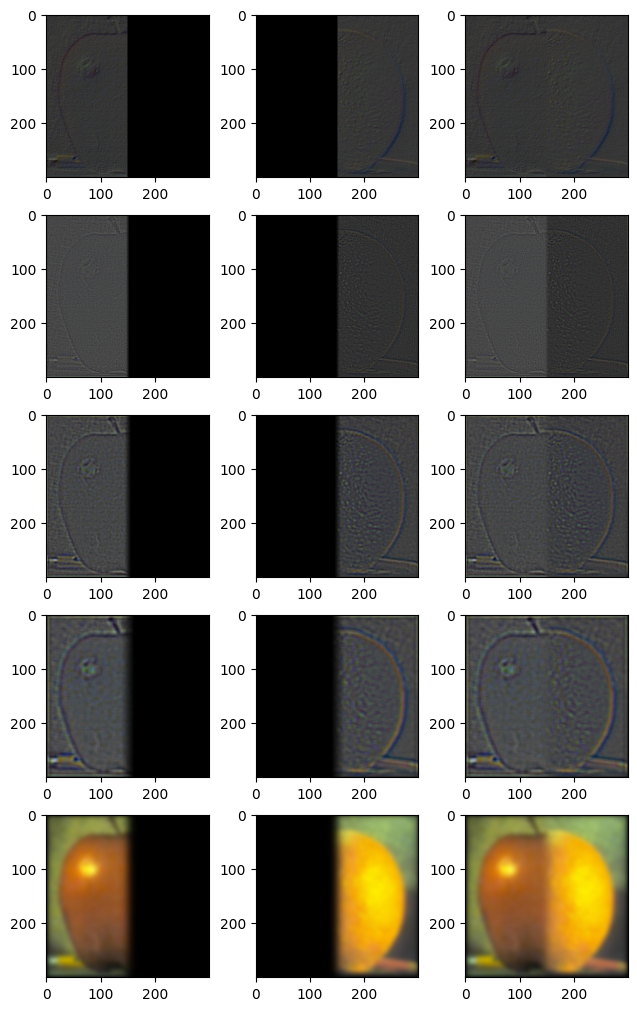

In [15]:
# Create final stack
blended_apple = []
blended_orange = []
final_stack = []
for i in range(len(apple_laplacian_stack)):
    la = normalize(mask_left_gs[i]) * normalize(apple_laplacian_stack[i])
    lb = normalize(mask_right_gs[i]) * normalize(orange_laplacian_stack[i])
    blended_apple.append(la)
    blended_orange.append(lb)
    final_stack.append(la + lb)

# display_stack(final_stack)

plt.figure(figsize=(16, 10), layout="compressed")
plt.subplot(531); plt.imshow(blended_apple[0], cmap="gray")
plt.subplot(532); plt.imshow(blended_orange[0], cmap="gray")
plt.subplot(533); plt.imshow(final_stack[0], cmap="gray")
plt.subplot(534); plt.imshow(blended_apple[1], cmap="gray")
plt.subplot(535); plt.imshow(blended_orange[1], cmap="gray")
plt.subplot(536); plt.imshow(final_stack[1], cmap="gray")
plt.subplot(537); plt.imshow(blended_apple[2], cmap="gray")
plt.subplot(538); plt.imshow(blended_orange[2], cmap="gray")
plt.subplot(539); plt.imshow(final_stack[2], cmap="gray")
plt.subplot(5,3,10); plt.imshow(blended_apple[3], cmap="gray")
plt.subplot(5,3,11); plt.imshow(blended_orange[3], cmap="gray")
plt.subplot(5,3,12); plt.imshow(final_stack[3], cmap="gray")
plt.subplot(5,3,13); plt.imshow(blended_apple[4], cmap="gray")
plt.subplot(5,3,14); plt.imshow(blended_orange[4], cmap="gray")
plt.subplot(5,3,15); plt.imshow(final_stack[4], cmap="gray")

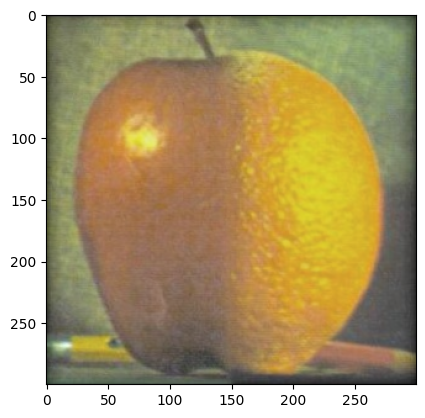

In [16]:
# Combine final stack
orapple = final_stack[-1]
for i in range(len(final_stack)-1, -1, -1):
    orapple += final_stack[i]
orapple_norm = normalize(orapple)
# print(orapple_norm.shape)
# print(orapple_norm)
plt.imshow(orapple_norm)

In [17]:
def blend(stack1, stack2, mask1, mask2):
    la_stack = []
    lb_stack = []
    final_stack = []
    for i in range(len(stack1)):
        la = normalize(mask1[i]) * normalize(stack1[i])
        lb = normalize(mask2[i]) * normalize(stack2[i])
        la_stack.append(la)
        lb_stack.append(lb)
        final_stack.append(la + lb)

    res = final_stack[-1]
    for i in range(len(final_stack)-1, -1, -1):
        res += final_stack[i]
    res = normalize(res)
    return [res, final_stack, la_stack, lb_stack]

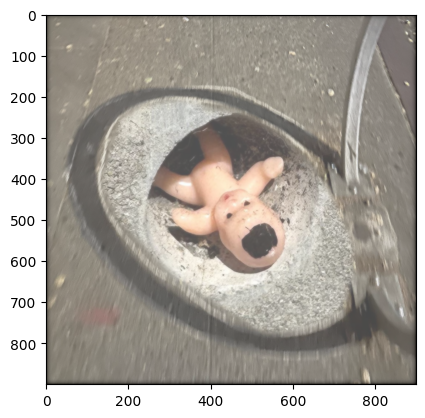

In [18]:
# Baby Portal
baby = plt.imread('../images/baby.jpg')/255
portal = plt.imread('../images/portal.jpg')/255

baby_gs = gaussian_stack(baby, 2, 32)
baby_ls = laplacian_stack(baby_gs)

portal_gs = gaussian_stack(portal, 2, 32)
portal_ls = laplacian_stack(portal_gs)

# Gaussian mask
mask_hole = plt.imread('../images/hole.jpg')/255
mask_surround = 1 - mask_hole
mask_hole_gs = gaussian_stack(mask_hole, 6, 64)
mask_surround_gs = gaussian_stack(mask_surround, 6, 64)

baby_portal, baby_portal_stack, bp_la_stack, bp_lb_stack = blend(baby_ls, portal_ls, mask_hole_gs, mask_surround_gs)
plt.imshow(baby_portal)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


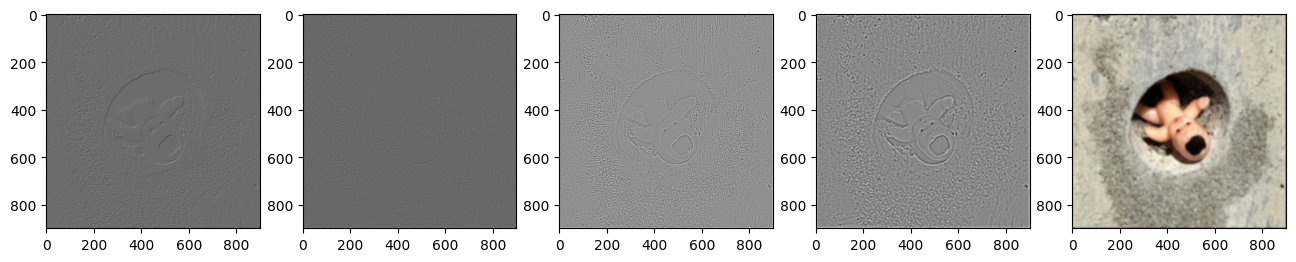

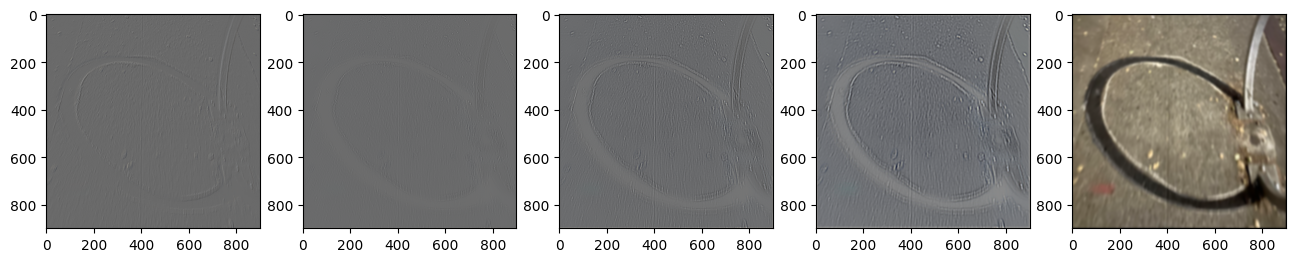

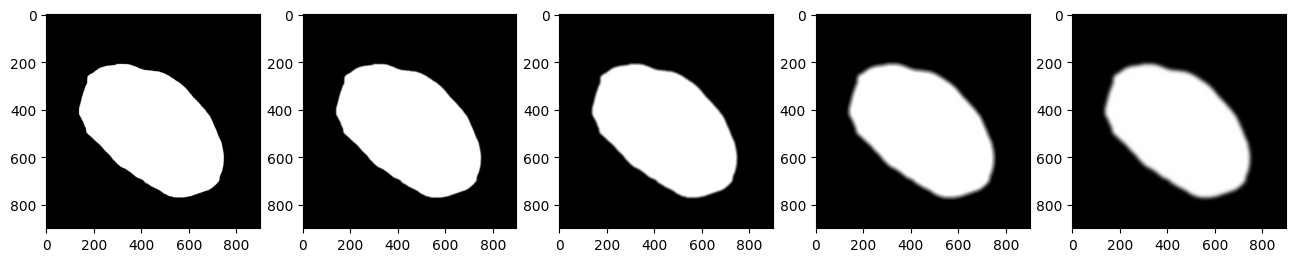

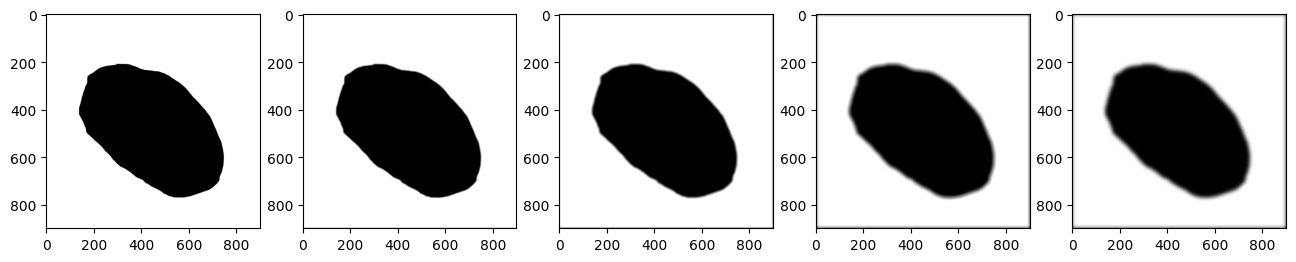

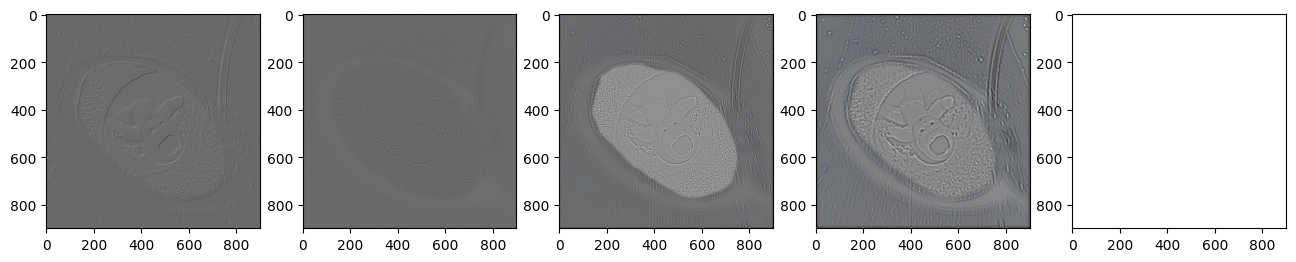

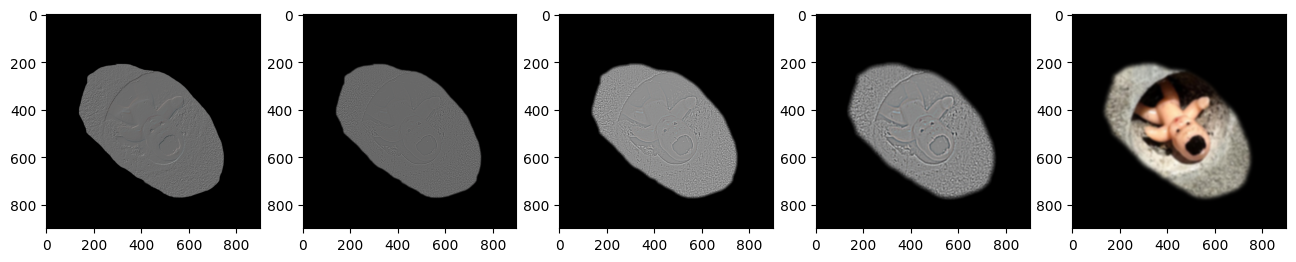

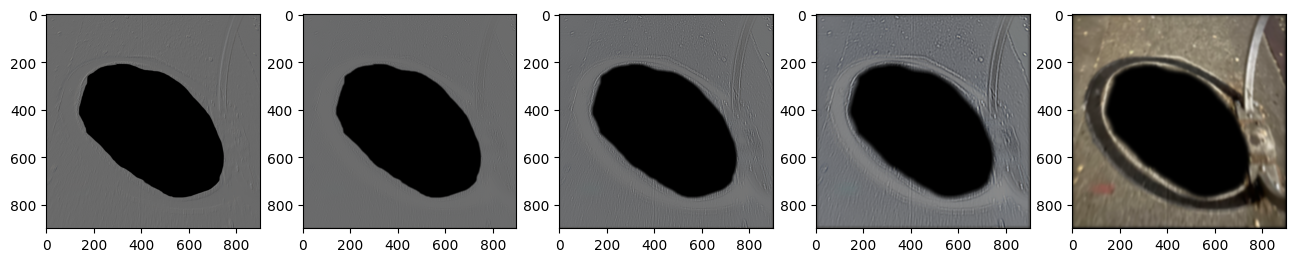

In [34]:
display_stack(baby_ls)
display_stack(portal_ls)
display_stack(mask_hole_gs)
display_stack(mask_surround_gs)
display_stack(baby_portal_stack)
display_stack(bp_la_stack)
display_stack(bp_lb_stack)

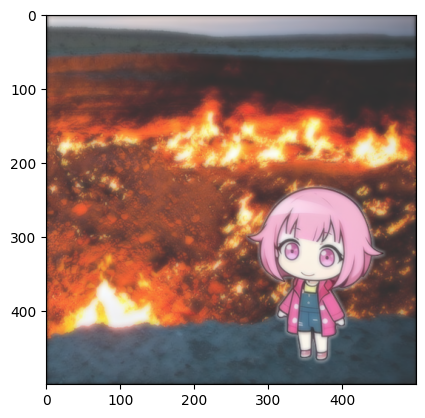

In [31]:
# Hi I'm Emu Otori
emu = plt.imread('../images/emu.jpg')/255
pit = plt.imread('../images/pit.jpg')/255

emu_gs = gaussian_stack(emu, 2, 32)
emu_ls = laplacian_stack(emu_gs)

pit_gs = gaussian_stack(pit, 8, 32)
pit_ls = laplacian_stack(pit_gs)

# Gaussian mask
mask_outline = plt.imread('../images/outline.jpg')/255
mask_background = 1 - mask_outline
mask_outline_gs = gaussian_stack(mask_outline, 1, 32)
mask_background_gs = gaussian_stack(mask_background, 1, 32)

emu_otori, emu_otori_stack, eo_la_stack, eo_lb_stack = blend(emu_ls, pit_ls, mask_outline_gs, mask_background_gs)
plt.imshow(emu_otori)

In [32]:
# Saving images
im_out = sk.img_as_ubyte(emu_otori)
fname = '../out_path/hi_im_emu/emu_otori.jpg'
skio.imsave(fname, im_out)

for i in range(len(emu_otori_stack)):
    im_out = sk.img_as_ubyte(normalize(emu_otori_stack[i]))
    fname = '../out_path/hi_im_emu/emu_otori_stack' + str(i) + '.jpg'
    skio.imsave(fname, im_out)

for i in range(len(eo_la_stack)):
    im_out = sk.img_as_ubyte(normalize(eo_la_stack[i]))
    fname = '../out_path/hi_im_emu/eo_la_stack' + str(i) + '.jpg'
    skio.imsave(fname, im_out)

for i in range(len(eo_lb_stack)):
    im_out = sk.img_as_ubyte(normalize(eo_lb_stack[i]))
    fname = '../out_path/hi_im_emu/eo_lb_stack' + str(i) + '.jpg'
    skio.imsave(fname, im_out)

im_out = sk.img_as_ubyte(baby_portal)
fname = '../out_path/baby_portal.jpg'
skio.imsave(fname, im_out)

for i in range(len(baby_portal_stack)):
    im_out = sk.img_as_ubyte(normalize(baby_portal_stack[i]))
    fname = '../out_path/baby_portal/baby_portal_stack' + str(i) + '.jpg'
    skio.imsave(fname, im_out)

for i in range(len(bp_la_stack)):
    im_out = sk.img_as_ubyte(normalize(bp_la_stack[i]))
    fname = '../out_path/baby_portal/bp_la_stack' + str(i) + '.jpg'
    skio.imsave(fname, im_out)

for i in range(len(bp_lb_stack)):
    im_out = sk.img_as_ubyte(normalize(bp_lb_stack[i]))
    fname = '../out_path/baby_portal/bp_lb_stack' + str(i) + '.jpg'
    skio.imsave(fname, im_out)

im_out = sk.img_as_ubyte(orapple_norm)
fname = '../out_path/orapple/orapple.jpg'
skio.imsave(fname, im_out)

for i in range(len(final_stack)):
    im_out = sk.img_as_ubyte(normalize(final_stack[i]))
    fname = '../out_path/orapple/orapple_stack' + str(i) + '.jpg'
    skio.imsave(fname, im_out)

for i in range(len(blended_apple)):
    im_out = sk.img_as_ubyte(normalize(blended_apple[i]))
    fname = '../out_path/orapple/blended_apple_stack' + str(i) + '.jpg'
    skio.imsave(fname, im_out)

for i in range(len(blended_orange)):
    im_out = sk.img_as_ubyte(normalize(blended_orange[i]))
    fname = '../out_path/orapple/blended_orange_stack' + str(i) + '.jpg'
    skio.imsave(fname, im_out)

In [30]:
im_out = sk.img_as_ubyte(hybrid)
fname = '../out_path/decat_res.png'
skio.imsave(fname, im_out)

im_out = sk.img_as_ubyte(se_hybrid)
fname = '../out_path/squail_res.png'
skio.imsave(fname, im_out)

im_out = sk.img_as_ubyte(li_hybrid)
fname = '../out_path/liger_res.png'
skio.imsave(fname, im_out)